# 05 Alternative regression model using MCMC + maximum likelihood 

> Implemented using metropolis hastings

In [1]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02b_LAD_and_GP_intersections.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02c_GP_doctors_per_LAD.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [2]:
#|default_exp core.05_alt_regression_model

In [3]:
#|hide 
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj 
from dementia_inequalities import const, log, utils, tools 
import adu_proj.utils as adutils 

In [5]:
#|export 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression


---

## Log normal distribution 

The shifted log-normal PDF at $x$ is: 

$$
p(x|x>\delta, \delta, \mu, \sigma) = 
\frac{1}{(x-\delta)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(x- \delta)-\mu)^2}
$$


In [14]:
#|export 

def shift_log_normal_pdf(x:np.array, 
                         delta:int, # shift parameter
                         mu:int, # mean of the variables log
                         sigma:int): # standard deviation of the variables log
    x_shift = x-delta
    norm_const = 1/((x_shift)*sigma*np.sqrt(2*np.pi))
    exp_part = np.exp(-(1/(2*sigma**2))*(np.log(x_shift)-mu)**2)
    return norm_const*exp_part

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10169/2586870590.py:9: RuntimeWarning: invalid value encountered in log
  exp_part = np.exp(-(1/(2*sigma**2))*(np.log(x_shift)-mu)**2)


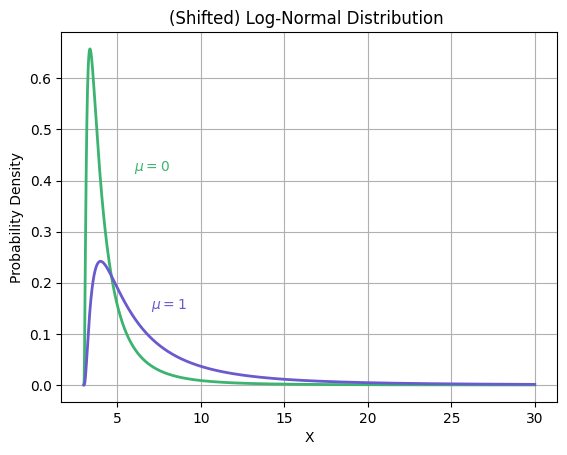

In [15]:
# Parameters for log-normal distribution
mu_0 = 0  # Mean
mu_1 = 1
sigma = 1  # Standard deviation
shift = 3 # Shift 

x = np.arange(1, 30, 0.01)

pdf_x_mu0 = shift_log_normal_pdf(x, shift, mu_0, sigma)
pdf_x_mu1 = shift_log_normal_pdf(x, shift, mu_1, sigma)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x, pdf_x_mu0, '-', linewidth=2, color='mediumseagreen')
plt.text(6, 0.42, '$\mu=0$', color='mediumseagreen')
plt.plot(x, pdf_x_mu1, '-', linewidth=2, color='slateblue')
plt.text(7, 0.15, '$\mu=1$', color='slateblue')

plt.title('(Shifted) Log-Normal Distribution ')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

### Evaluating the log-posterior using MCMC 

We evaluate the log-posterior using MCMC, specificlaly metropolis hastings. This code is written with a little help from my firend ChatGPT - actually it generated the intial code - then I re-wrote 70% of it... 

*Note*: we need the likelihood to be the shifted log normal - which has an extra parameter (delta) compared to the log normal [see here](https://stats.stackexchange.com/questions/379980/understanding-the-shifted-log-normal-distribution). 

The shifted log-normal PDF at $x$ is: 

$$
p(x|x>\delta, \delta, \mu, \sigma) = 
\frac{1}{(x-\delta)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(x- \delta)-\mu)^2}
$$

In the log-normal distribution, 
- $\mu$ is the scale parameter - it stretches and compresses
- $\sigma$ is a shape parameter - it controls how skewed/heavy tailed the distribution is. 

The shift is the linear equation: $\delta = \beta X$

So as a result the likelihood becomes: 

$$
L(\delta, \mu, \sigma) = \prod_{i=1}^n s(y_i | \beta X, \mu, \sigma) \\

= \prod_{i=1}^n \frac{1}{(y_i-\beta X_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(y_i- \beta X_i)-\mu)^2}
$$

With a log-likelihood of: 

$$
= \sum_{i=1}^n log(\frac{1}{(y_i-\beta X_i)\sigma \sqrt{2 \pi}} e^{-\frac{1}{2 \sigma^2}(ln(y_i- \beta X_i)-\mu)^2})
\\ 
= \sum_{i=1}^n -\frac{1}{2 \sigma^2}(ln(y_i- \beta X_i)-\mu)^2ln(\frac{1}{(y_i-\beta X_i)\sigma \sqrt{2 \pi}}) 
\\ 
= -\frac{1}{2 \sigma^2} \sum_{i=1}^n (ln(y_i- \beta X_i)-\mu)^2ln(\frac{1}{(y_i-\beta X_i)\sigma \sqrt{2 \pi}}) 
\\ 
= \frac{1}{2 \sigma^2} \sum_{i=1}^n (ln(y_i- \beta X_i)-\mu)^2ln((y_i-\beta X_i)\sigma \sqrt{2 \pi}) 
$$


In [17]:
#|export 

# Define the log likelihood function for linear regression with log-normal error
def log_likelihood(params, X, y):
    beta = params[:-2]
    mu = params[-2]
    sigma = params[-1]
    y_pred = np.dot(X, beta) # this is the shift 
    likelihood = shift_log_normal_pdf(y, delta=y_pred, mu=mu, sigma=sigma)
    return np.sum(np.log(likelihood))

# Define the prior distribution for beta parameters, mu, and sigma
def log_prior(params):
    beta = params[:-2]
    mu = params[-2]
    sigma = params[-1]
    if np.all(-10 < beta.all() < 10) and 0 <= mu < 10 and sigma > 0:
        return 0
    return -np.inf

# Define the log posterior distribution
def log_posterior(params, X, y):
    return log_likelihood(params, X, y) + log_prior(params)

# Define the Metropolis-Hastings algorithm
def metropolis_hastings(initial_params, proposal_sd, n_iter, X, y):
    params = initial_params
    accepted_params = [params]
    accepted_post = [log_posterior(params, X, y)]
    for _ in range(n_iter):
        proposed_params = params + np.random.normal(scale=proposal_sd, size=params.shape)
        log_alpha = log_posterior(proposed_params, X, y) - log_posterior(params, X, y)
        if np.log(np.random.rand()) < log_alpha:
            params = proposed_params
        accepted_params.append(params)
        accepted_post.append(log_posterior(params, X, y))
    return np.array(accepted_params), np.array(accepted_post)

In [20]:
# Generate some sample data with 7 covariates
np.random.seed(0)
n_samples = 1000
n_features = 7
X = np.random.rand(n_samples, n_features) * 10  # Independent variables
true_beta = np.random.normal(loc=2, scale=1, size=n_features)  # True coefficients
true_mu = 0  # True mean of log-normal distribution
true_sigma = 1
true_error = np.random.lognormal(mean=true_mu, sigma=true_sigma, size=n_samples)  # Log-normal error term
y = np.dot(X, true_beta) + true_error  # True relationship with error

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10169/3980381883.py:8: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(likelihood))
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10169/3980381883.py:8: RuntimeWarning: invalid value encountered in log
  return np.sum(np.log(likelihood))
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10169/2586870590.py:9: RuntimeWarning: invalid value encountered in log
  exp_part = np.exp(-(1/(2*sigma**2))*(np.log(x_shift)-mu)**2)


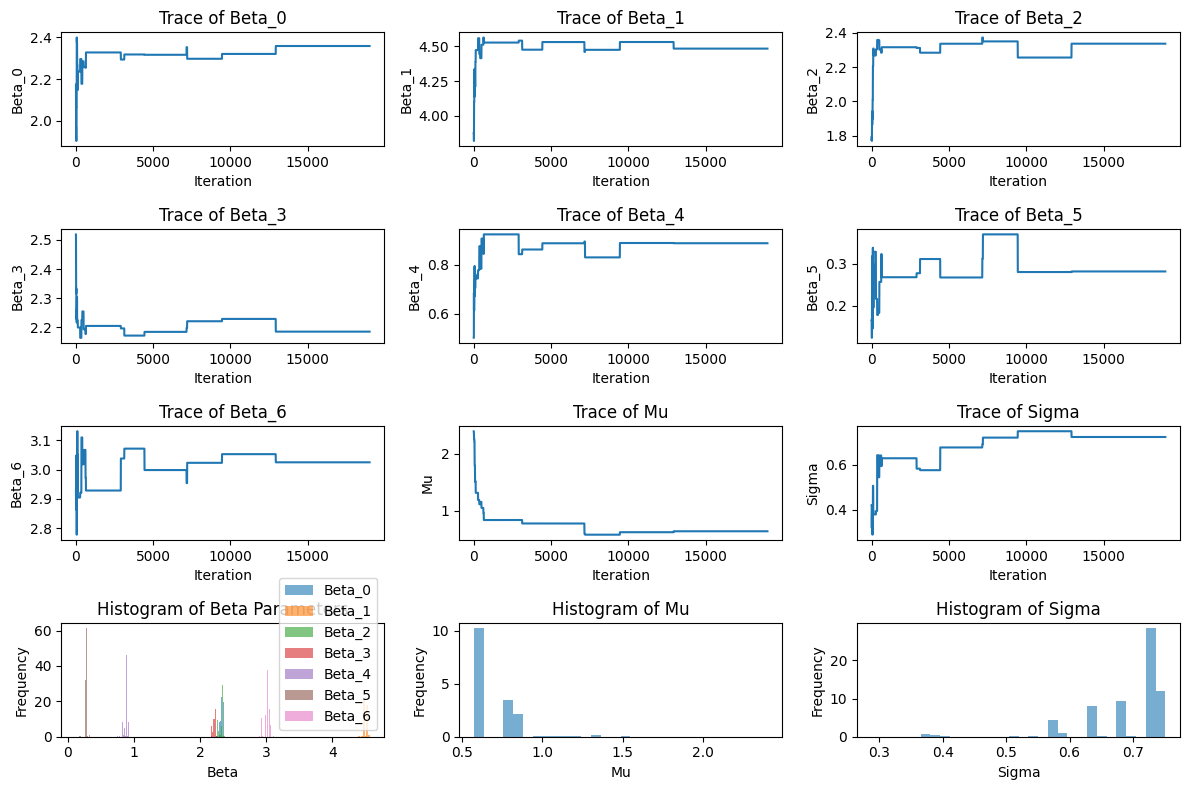

In [21]:
# Set initial parameters and proposal standard deviation
initial_params = np.concatenate([np.random.normal(size=n_features), [0, 1]])  # Initial beta parameters, mu, and sigma
proposal_sd = 0.1

# Run Metropolis-Hastings algorithm
n_iter = 20000
chain, post = metropolis_hastings(initial_params, proposal_sd, n_iter, X, y)

# Burn-in (discard first part of the chain)
burn_in = 1000
burned_chain = chain[burn_in:]

# Extract beta parameters, mu, and sigma from the chain
beta_samples, mu_samples, sigma_samples = burned_chain[:, :-2], burned_chain[:, -2], burned_chain[:, -1]

# Plot the traces and histograms of beta parameters, mu, and sigma
plt.figure(figsize=(12, 8))

for i in range(n_features):
    plt.subplot(4, 3, i+1)
    plt.plot(beta_samples[:, i])
    plt.xlabel('Iteration')
    plt.ylabel(f'Beta_{i}')
    plt.title(f'Trace of Beta_{i}')

plt.subplot(4, 3, n_features+1)
plt.plot(mu_samples)
plt.xlabel('Iteration')
plt.ylabel('Mu')
plt.title('Trace of Mu')

plt.subplot(4, 3, n_features+2)
plt.plot(sigma_samples)
plt.xlabel('Iteration')
plt.ylabel('Sigma')
plt.title('Trace of Sigma')

plt.subplot(4, 3, n_features+3)
for i in range(n_features):
    plt.hist(beta_samples[:, i], bins=30, density=True, alpha=0.6, label=f'Beta_{i}')
plt.xlabel('Beta')
plt.ylabel('Frequency')
plt.title('Histogram of Beta Parameters')
plt.legend()

plt.subplot(4, 3, n_features+4)
plt.hist(mu_samples, bins=30, density=True, alpha=0.6)
plt.xlabel('Mu')
plt.ylabel('Frequency')
plt.title('Histogram of Mu')

plt.subplot(4, 3, n_features+5)
plt.hist(sigma_samples, bins=30, density=True, alpha=0.6)
plt.xlabel('Sigma')
plt.ylabel('Frequency')
plt.title('Histogram of Sigma')

plt.tight_layout()
plt.show()


In [22]:
# Extract the mode (most frequent value) from the parameter samples
mode_beta = np.median(beta_samples, axis=0)
mode_mu = np.median(mu_samples)
mode_sigma = np.median(sigma_samples)

print("Mode estimates:")
print("Beta:", mode_beta)
print("Mu:", mode_mu)
print("Sigma:", mode_sigma)

Mode estimates:
Beta: [2.32060916 4.48346297 2.33542347 2.18531498 0.88679444 0.28169254
 3.02473825]
Mu: 0.6343199557104399
Sigma: 0.725165190749936


In [23]:
# Extract the MAP from the parameter samples
MAP_params = chain[np.argmax(post)]
MAP_beta = MAP_params[:-2]
MAP_mu = MAP_params[-2]
MAP_sigma = MAP_params[-1]

print("MAP estimates:")
print("Beta:", MAP_beta)
print("Mu:", MAP_mu)
print("Sigma:", MAP_sigma)

MAP estimates:
Beta: [2.3586377  4.48346297 2.33573018 2.18531498 0.88679444 0.28169254
 3.02473825]
Mu: 0.6343199557104399
Sigma: 0.725165190749936


In [24]:
print("True parameter values:")
print("Beta:", true_beta)
print("Mu:", true_mu)
print("Sigma:", true_sigma)

True parameter values:
Beta: [2.33262315 4.49599456 2.3348725  2.24408513 0.91852546 0.32878941
 3.0294515 ]
Mu: 0
Sigma: 1


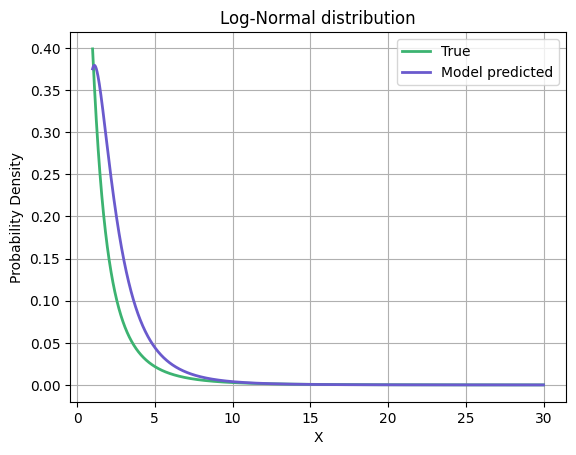

In [25]:
# Compare the true log-normal to that from the model 

# Parameters for log-normal distribution
shift = 0 # Shift 

x = np.arange(1, 30, 0.01)

pdf_x_true = shift_log_normal_pdf(x, shift, true_mu, true_sigma)
pdf_x_MAP = shift_log_normal_pdf(x, shift, MAP_mu, MAP_sigma)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x, pdf_x_true, '-', linewidth=2, color='mediumseagreen', label='True')
plt.plot(x, pdf_x_MAP, '-', linewidth=2, color='slateblue', label='Model predicted')

plt.title('Log-Normal distribution')
plt.legend(loc='upper right')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

### With the real data! 

In [43]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,0.932,0.012269,0.480252,0.342754,0.604124,0.190731,0.061649,0.029487,215.158147,0.001420
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,0.630,0.006481,0.720170,0.201778,0.645599,0.103726,0.036506,0.012880,437.450820,0.002790
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,0.842,0.009222,0.551399,0.237524,0.626593,0.135847,0.048480,0.019880,123.466346,0.001299
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,0.878,0.009969,0.533413,0.239143,0.589346,0.136400,0.055064,0.021488,612.399689,0.004970
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,0.938,0.008057,0.488182,0.294860,0.625728,0.159655,0.062981,0.022507,77.360723,0.001138


In [48]:
# The real dementia X and y data 

# covariates 
X_covar = df_dem_plus[['over_65_pc', 'female_pc', 'ALevel_plus_pc']].values.reshape(-1,3)
#covar = df_dem_plus[['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc']].values.reshape(-1,7)

# Outcome data 
Y_data = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10169/2586870590.py:9: RuntimeWarning: invalid value encountered in log
  exp_part = np.exp(-(1/(2*sigma**2))*(np.log(x_shift)-mu)**2)


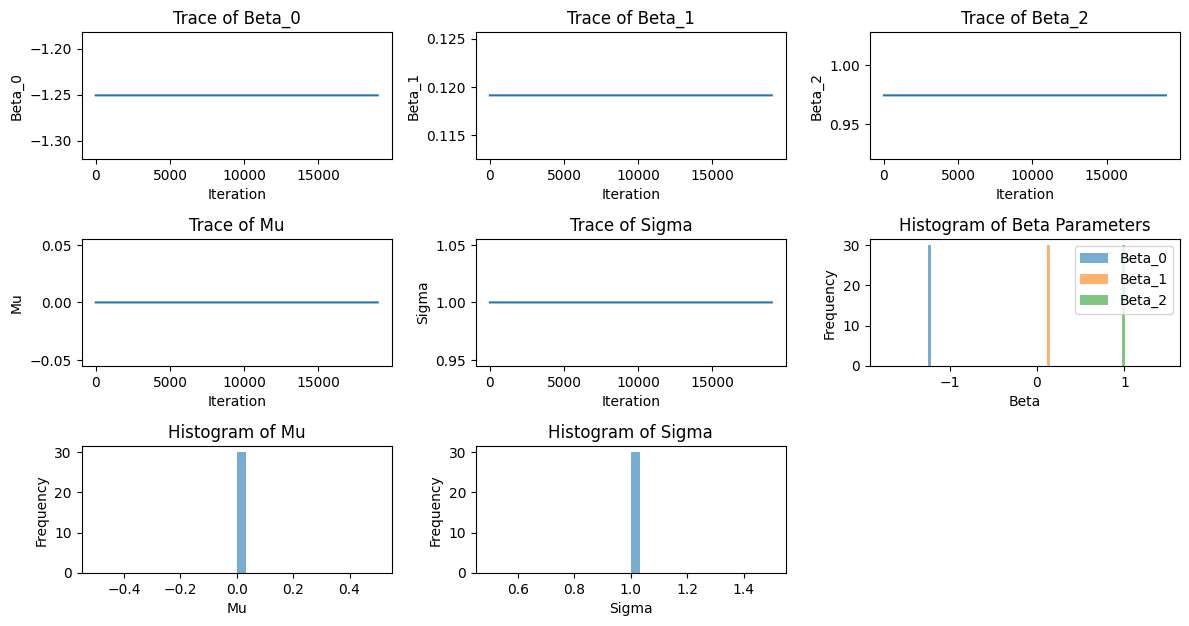

In [55]:
n_features = X_covar.shape[1]

# Set initial parameters and proposal standard deviation
initial_params = np.concatenate([np.random.normal(size=n_features), [0, 1]])  # Initial beta parameters, mu, and sigma
proposal_sd = 0.1

# Run Metropolis-Hastings algorithm
n_iter = 20000
chain, post = metropolis_hastings(initial_params, proposal_sd, n_iter, X_covar, Y_data)

# Burn-in (discard first part of the chain)
burn_in = 1000
burned_chain = chain[burn_in:]

# Extract beta parameters, mu, and sigma from the chain
beta_samples, mu_samples, sigma_samples = burned_chain[:, :-2], burned_chain[:, -2], burned_chain[:, -1]

# Plot the traces and histograms of beta parameters, mu, and sigma
plt.figure(figsize=(12, 8))

for i in range(n_features):
    plt.subplot(4, 3, i+1)
    plt.plot(beta_samples[:, i])
    plt.xlabel('Iteration')
    plt.ylabel(f'Beta_{i}')
    plt.title(f'Trace of Beta_{i}')

plt.subplot(4, 3, n_features+1)
plt.plot(mu_samples)
plt.xlabel('Iteration')
plt.ylabel('Mu')
plt.title('Trace of Mu')

plt.subplot(4, 3, n_features+2)
plt.plot(sigma_samples)
plt.xlabel('Iteration')
plt.ylabel('Sigma')
plt.title('Trace of Sigma')

plt.subplot(4, 3, n_features+3)
for i in range(n_features):
    plt.hist(beta_samples[:, i], bins=30, density=True, alpha=0.6, label=f'Beta_{i}')
plt.xlabel('Beta')
plt.ylabel('Frequency')
plt.title('Histogram of Beta Parameters')
plt.legend()

plt.subplot(4, 3, n_features+4)
plt.hist(mu_samples, bins=30, density=True, alpha=0.6)
plt.xlabel('Mu')
plt.ylabel('Frequency')
plt.title('Histogram of Mu')

plt.subplot(4, 3, n_features+5)
plt.hist(sigma_samples, bins=30, density=True, alpha=0.6)
plt.xlabel('Sigma')
plt.ylabel('Frequency')
plt.title('Histogram of Sigma')

plt.tight_layout()
plt.show()


In [56]:
# Extract the MAP from the parameter samples
MAP_params = chain[np.argmax(post)]
MAP_beta = MAP_params[:-2]
MAP_mu = MAP_params[-2]
MAP_sigma = MAP_params[-1]

print("MAP estimates:")
print("Beta:", MAP_beta)
print("Mu:", MAP_mu)
print("Sigma:", MAP_sigma)

MAP estimates:
Beta: [-1.25077622  0.11912887  0.97423452]
Mu: 0.0
Sigma: 1.0


/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10169/2586870590.py:8: RuntimeWarning: divide by zero encountered in divide
  norm_const = 1/((x_shift)*sigma*np.sqrt(2*np.pi))
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10169/2586870590.py:9: RuntimeWarning: divide by zero encountered in log
  exp_part = np.exp(-(1/(2*sigma**2))*(np.log(x_shift)-mu)**2)
/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_10169/2586870590.py:10: RuntimeWarning: invalid value encountered in multiply
  return norm_const*exp_part


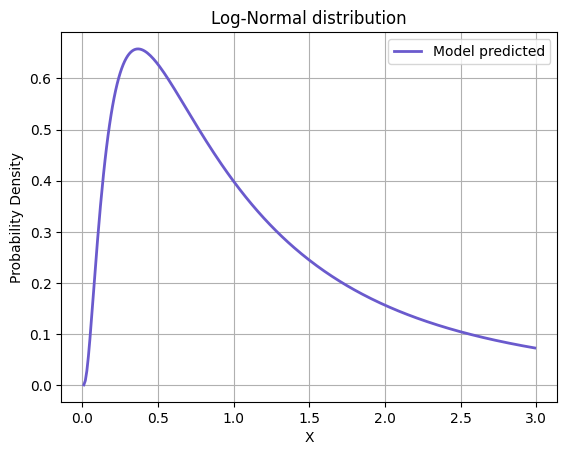

In [57]:
# Compare the true log-normal to that from the model 

# Parameters for log-normal distribution
shift = 0 # Shift 

x = np.arange(0, 3, 0.01)

pdf_x_MAP = shift_log_normal_pdf(x, shift, MAP_mu, MAP_sigma)

# Plot the log-normal probability density function (PDF)
xmin, xmax = plt.xlim()
plt.plot(x, pdf_x_MAP, '-', linewidth=2, color='slateblue', label='Model predicted')

plt.title('Log-Normal distribution')
plt.legend(loc='upper right')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()